In [3]:
import pandas as pd
import numpy as np
from random import sample
from sklearn import linear_model as sklm
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%pylab inline



Bad key "back end" on line 1 in
/Users/bethevans/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Populating the interactive namespace from numpy and matplotlib


/Users/bethevans/.virtualenvs/zoopy/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
def separate_dates(dataframe, col1, col2):
    '''Function takes a dataframe and two column names. Function adds 
        an additional two columns to the dataframe with the year of the strain in YYYY form
        '''
    
    strain_1_labels = list(dataframe[col1])
    strain_2_labels = list(dataframe[col2])
    
    strain_1_dates = []
    strain_2_dates = []
    
    for label in strain_1_labels:
        date = int(list(label.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_1_dates.append(date)
        
    for label2 in strain_2_labels:
        date = int(list(label2.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_2_dates.append(date)
    
    dataframe['strain_1_dates'] = pd.Series(strain_1_dates, index=dataframe.index)
    dataframe['strain_2_dates'] = pd.Series(strain_2_dates, index=dataframe.index)

In [5]:
def print_full(x):
    pd.set_option('display.max_columns', len(x))
    print(x)
    pd.reset_option('display.max_columns')

In [6]:
file = open('data.csv')
df = pd.read_csv(file)
df = df.drop(0)
separate_dates(df, 'AG1', 'AG2')

In [7]:
#print_full(df)

In [39]:
def random_sample(dataframe):
    '''Function splits the dataframe into training and test data.
    Testsize should be a decimal e.g. 0.2 means 80% data = train; 20% data = test'''
    
    global unseen, dftest, Xtrain, Xtest, ytrain, ytest, Xtrain_noham, Xtrain_ham, Xtest_noham, Xtest_ham
    
    dftrain, dftest = train_test_split(dataframe, test_size = 0.2)
    Xtrain = dftrain.drop(['AG1', 'AG2', 'strain_1_dates', 'strain_2_dates'], axis = 1)
    Xtest = dftest.drop(['AG1', 'AG2', 'strain_1_dates', 'strain_2_dates'], axis = 1)
    
    #remove rows with unseen substitutions
    unseen = []
    for column in Xtrain.columns:
        if sum(Xtrain[column]) == 0:
            unseen.append(column)
    print unseen
    for item in unseen:
        Xtrain = Xtrain[Xtrain[item] != 1]
        Xtest = Xtest[Xtest[item] != 1]
    
    #create X and y training and test data - for both
    ytrain = Xtrain['AG-DIST']
    ytest = Xtest['AG-DIST']
    Xtrain = Xtrain.drop(['AG-DIST'], axis = 1)
    Xtest = Xtest.drop(['AG-DIST'], axis = 1)
    
    #create X training and test data - remove hamming distance
    Xtrain_noham = Xtrain.drop(['NUM-MUTATIONS'], axis = 1)
    Xtrain_ham = Xtrain['NUM-MUTATIONS']
    Xtest_noham = Xtest.drop(['NUM-MUTATIONS'], axis = 1)
    Xtest_ham = Xtest['NUM-MUTATIONS']

In [112]:
random_sample(df)

['CF139', 'GR146', 'IK050', 'IK145', 'NR145', 'NV031']


In [135]:
#run with both hamming distance and amino acid substitutions

both = sklm.Ridge(alpha=300)
both.fit(Xtrain, ytrain)
score = both.score(Xtest, ytest)
print(score)

coef_dict = {}
for coef, subs in zip(both.coef_, Xtrain.columns):
    coef_dict[subs] = coef


print [[key, value] for key, value in coef_dict.items() if '031' in key.lower()]

0.635627026878
[['DN031', -0.023517450664477624], ['NV031', 0.0]]


In [136]:
def average(unseen_item_list):
    positions = []
    averages_list = []
    updated_items = {}
    for item in unseen_item_list:
        position = item[2:5]
        positions.append(position)
        local_positions = [int(position)-1, int(position), int(position)+1]
        local_coefs = []
        for local_pos in local_positions:
            other_coefs_at_pos = [value for key, value in coef_dict.items() 
                                    if str(local_pos) in key.lower()]
            local_coefs += other_coefs_at_pos
        average = np.mean(local_coefs)
        updated_items.update({item: average})
        coef_dict[item] = average
    
    print updated_items

average(unseen)
both.coef_= coef_dict.values
print [[key, value] for key, value in coef_dict.items() if '031' in key.lower()]

{'IK145': 0.087211820433015688, 'NV031': -0.0032191988612091985, 'CF139': 0.0097568135294843171, 'IK050': -0.015679805772939277, 'GR146': 0.11870546513506167, 'NR145': 0.092341927517310726}
[['DN031', -0.023517450664477624], ['NV031', -0.0032191988612091985]]


In [9]:
#Must reshape data that is in single column format for use in linear regression below

Xtrain_ham = Xtrain_ham.reshape(-1,1)
Xtest_ham = Xtest_ham.reshape(-1,1)
ytrain = ytrain.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)

In [ ]:
#other bits of code you might want to use to check stuff

#print Xtrain_ham.shape
#print ytrain.shape
#print Xtest_ham.shape
#print ytest.shape

In [10]:
#run with hamming distance only
ham = sklm.LinearRegression()
ham.fit(Xtrain_ham, ytrain)
score = ham.score(Xtest_ham, ytest)
print(score)

0.194252770599


In [11]:
#run with amino acid substitutions only
aasub = sklm.LinearRegression()
aasub.fit(Xtrain_noham, ytrain)
score = aasub.score(Xtest_noham, ytest)
print(score)

0.715615313356


In [12]:
#other beth's error plot

def errorplot(clf, xtst):
    fig_size = [15, 6]
    plt.rcParams["figure.figsize"] = fig_size
    
    #Make a dataframe 'errors' to hold the ytest, predicted values, and errors, then sort by the error size
    errors = pd.DataFrame(data=ytest, columns =('AG-DIST',))
    errors['predicted'] = clf.predict(xtst)
    errors['error'] = errors['predicted'] - errors['AG-DIST']
    errors['date'] = dftest['strain_2_dates']
    errors = errors.sort_values('error')

    plt.figure(3)
    errors = errors.sort_values('date')
    
    #Add some random noise to the dates to avoid overplotting
    errors['jittered_dates'] = errors['date'] + np.random.uniform(-2, 2, len(ytest))
    
    plt.scatter(errors['jittered_dates'], errors['AG-DIST'], color = 'g', s=3, marker='o')
    plt.scatter(errors['jittered_dates'], errors['predicted'], color = 'b', s=3)
    plt.scatter(errors['jittered_dates'], errors['error'], color = 'r', s=3)
    plt.xlabel('Strain 2 dates')
    plt.ylabel('Antigenic distance')
    red_patch = mpatches.Patch(color='red', label='Error')
    green_patch = mpatches.Patch(color='green', label='True value')
    blue_patch = mpatches.Patch(color='blue', label='Predicted value')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    
    plt.figure(4)
    plt.hist(errors['error'], bins=30)
    plt.xlabel('error size')
    plt.ylabel('frequency')
    #plt.axvline(x=mean(errors['error']), color='r')

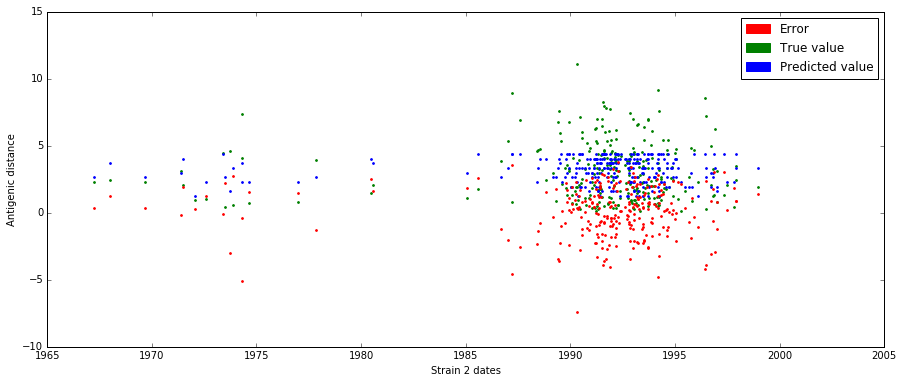

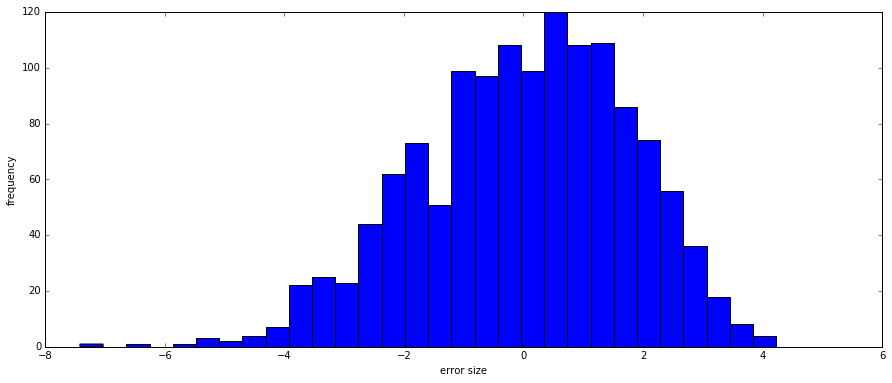

In [13]:
errorplot(ham, Xtest_ham)

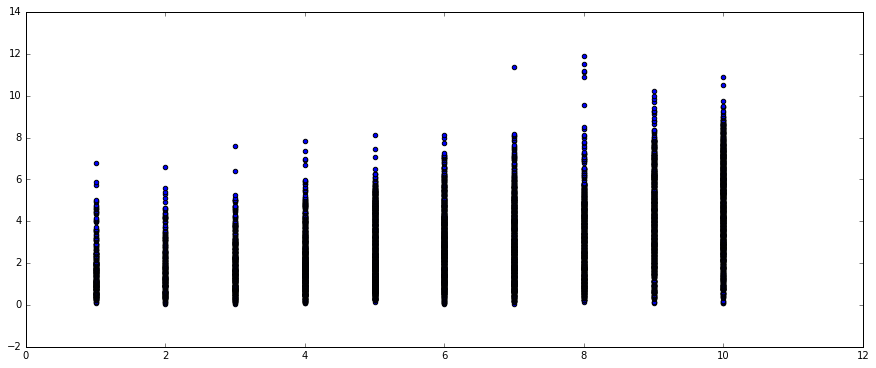

In [14]:
plt.scatter(df['NUM-MUTATIONS'], df['AG-DIST'])

(0, 17)

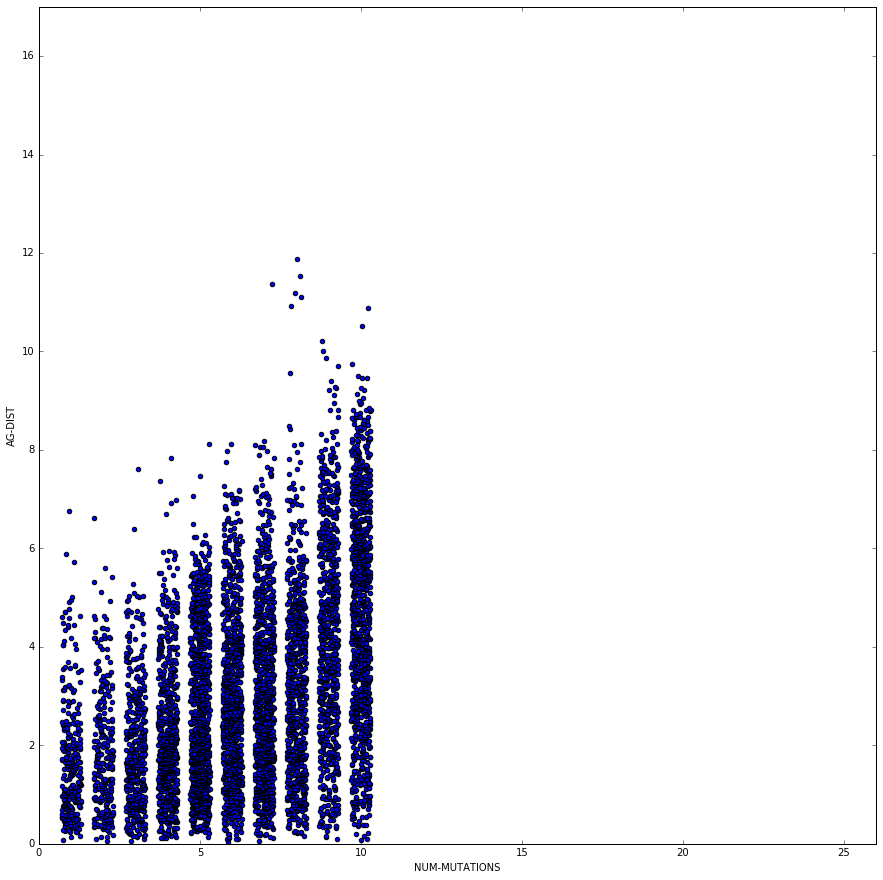

In [15]:
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size
jitteredHD = df['NUM-MUTATIONS'] + np.random.uniform(-0.3, 0.3, len(df))
plt.xlabel('NUM-MUTATIONS')
plt.ylabel('AG-DIST')
plt.scatter(jitteredHD, df['AG-DIST'])
plt.xlim(0,26)
plt.ylim(0,17)